# Data Generation
We generate some toy datasets to test out our bayesian inference.

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import arviz as az
torch.set_default_dtype(torch.float64)
torch.manual_seed(2026)

In [2]:
def rbf(x, l, sf2, sn2):
    squares = torch.sum(((x.unsqueeze(1)-x.unsqueeze(0))/l)**2, dim=2)
    K = sf2*torch.exp(-1/2*squares) + sn2*torch.eye(len(x)) # Stability
    return K

In [3]:
def generate_gp(l, sf2, sn2, x):
    """ Generate sample sample from an rbf gp with given lengthscales
    l1: lengthscalles
    sf2: output scale
    x: matrix of points to sample at
    
    Assume the covariance matrix is not too close to statinary i.e. relatively
    large lengthscales. If it's closer to stationary RFF might be better
    """
    K = rbf(x, l, sf2, sn2)
    L = torch.linalg.cholesky(K)
    y = torch.sqrt(sf2)*(L @ torch.randn(len(x)))
    return y

In [4]:
n = 10
d = 1
noise = 1e-2
x = torch.rand(n, d)*2-1 # Scale from -1 to 1
theta = torch.randn(d+1) # Underlying parameter
l = torch.exp(theta[:d])
sf2 = torch.exp(theta[-1])

def logptheta(theta):
    return -(d+1)/2*math.log(2*torch.pi) - 1/2*torch.sum(theta*theta)
def grad_logptheta(theta):
    return -theta


In [5]:
y = generate_gp(l, sf2, noise, x)

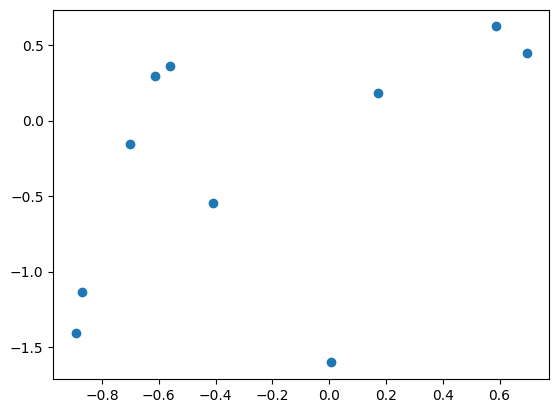

In [6]:
plt.scatter(x, y)

In [7]:
y

tensor([ 0.3644,  0.4465, -0.1550, -1.1369,  0.1810, -1.6024,  0.6230,  0.2971,
        -0.5448, -1.4050])

In [8]:
def gp_lml(x, y, l, sf2, sn2):
    """ Calculate log-marginal-likelihood given specific parameters """
    K = rbf(x, l, sf2, sn2)
    comp = y @ torch.linalg.solve(K, y)
    fit = torch.logdet(K)
    lml = -1/2*(comp+fit)
    return lml

In [9]:
gp_lml(x, y, l, sf2, noise)

tensor(0.9728)

We seed our likelihood model with a few observations taken from the prior.

In [10]:
m = 100
bounds = 5
alpha = torch.rand(m, d+1)*2*bounds - bounds # Generate theta from prior
beta = torch.tensor([gp_lml(x,y,torch.exp(a[:d]),torch.exp(a[-1]), noise) for a in alpha])

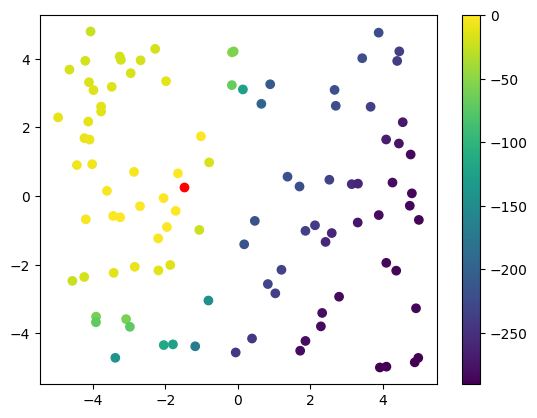

In [11]:
plt.scatter(theta[0], theta[1], c="r")
plt.scatter(alpha[:,0], alpha[:,1], c=beta)
plt.colorbar()

In low dimensions we can use a sobol sequence to get an idea of the log-likelihood.

Now we have our likelihood evaluations, we can construct a GP model OF the log likelihood function. To keep things simple, we will just use MLE to find the meta hyperparameters.

tensor([ 0.3235,  1.5428, -0.4144], requires_grad=True)
tensor([1.3819, 4.6777])
tensor(0.6608)


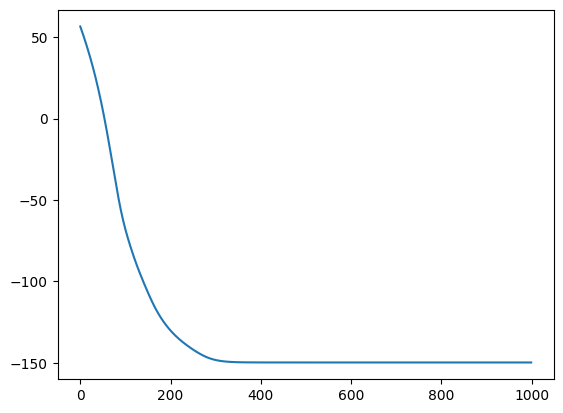

In [12]:
# Optimize over theta
# Scale and center likelihood observations
mu = torch.mean(beta)
s2 = torch.var(beta)
gamma = (beta - mu)/math.sqrt(s2)

# Metaparamters
# Extra paramter since we model over output scale too
xi = torch.randn(d+2, requires_grad=True)
optimizer = optim.Adam((xi,), lr=1e-2)
losses = []
this_noise = noise

# TODO could add multistart, might get us a better model
for i in range(1000):
    this_l = torch.exp(xi[:d+1])*math.sqrt(d) # Scale for dimension
    this_s2 = torch.exp(xi[-1])
    loss = -gp_lml(alpha, gamma, this_l, this_s2, this_noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print(f"Iteration {i}. Loss = {loss.item()}")
    losses.append(loss.item())
plt.plot(losses)
print(xi)
with torch.no_grad():
    print(torch.exp(xi[:d+1])*math.sqrt(d))
    print(torch.exp(xi[-1]))

TODO: double check the predictions of this GP... something is sus..

Now that we have a *model* of the posterior we can try to sample from it using our version of MALA.

In [13]:
xi.detach_()
lp = torch.exp(xi[:d+1])*math.sqrt(d) # Scale for dimension
sp2 = torch.exp(xi[-1])
K = rbf(alpha, lp, sp2, noise) # maybe this noise?
Kinv = torch.linalg.inv(K) # Precompute inverse, maybe better to use cholesky

In [14]:
print(f"{lp = }, {sp2 = }")

lp = tensor([1.3819, 4.6777]), sp2 = tensor(0.6608)


In [15]:
zeta = torch.randn(d+1) # Sample starting at zeta

In [16]:
def cross_mean(zeta, alpha, l, sf2):
    """Compute the cross covariance of zeta and grad zeta with alphas"""
    z = zeta.unsqueeze(0).unsqueeze(1)
    a = alpha.unsqueeze(0)
    squares = torch.sum(((z-a)/l)**2, dim=2)
    K1 = sf2*torch.exp(-1/2*squares) # 1 x m matrix
    return K1
cross_mean(zeta, alpha, lp, sp2).shape

torch.Size([1, 100])

In [17]:
def cross_rbf(zeta, alpha, l, sf2):
    """Compute the cross covariance of zeta and grad zeta with alphas"""
    z = zeta.unsqueeze(0).unsqueeze(1)
    a = alpha.unsqueeze(0)
    squares = torch.sum(((z-a)/l)**2, dim=2)
    K1 = sf2*torch.exp(-1/2*squares) # 1 x m matrix
    K2 = K1*((zeta-alpha)/l**2).T 
    return torch.cat((K1, K2), dim = 0)
cross_rbf(zeta, alpha, lp, sp2).shape

torch.Size([3, 100])

We can visualize the GP mean and variance to make sure the model is reasonable.

In [18]:
weights = Kinv @ gamma
def gp_mean(x):
    k = cross_mean(x, alpha, lp, sp2)
    return k @ weights
def gp_var(x):
    k = cross_mean(x, alpha, lp, sp2)
    return sp2 - (k @ (Kinv @ k.T)).item()
# gp_mean(torch.randn(d+1))
gp_var(torch.randn(d+1))

tensor(0.0029)

/Users/zacharylau/Desktop/School/2025-26/Bayesian Workflows/project/project/.venv/lib/python3.13/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4383.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


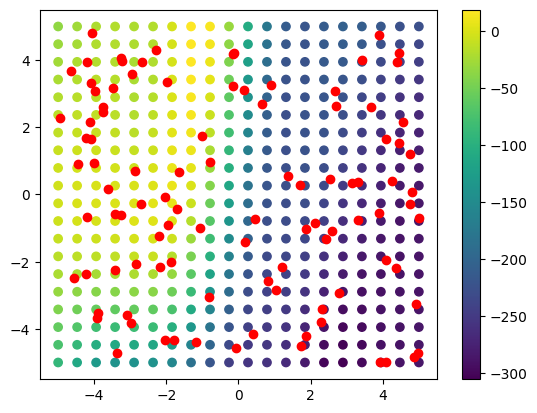

In [19]:
grid_bounds = bounds
grid = torch.linspace(-grid_bounds, grid_bounds, 20)
x_test = torch.stack([a.flatten() for a in torch.meshgrid(grid, grid)], dim = 1)
y_test = [gp_mean(x)*torch.sqrt(s2)+mu for x in x_test]
plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.colorbar()
plt.scatter(alpha[:,0], alpha[:,1], color="r")

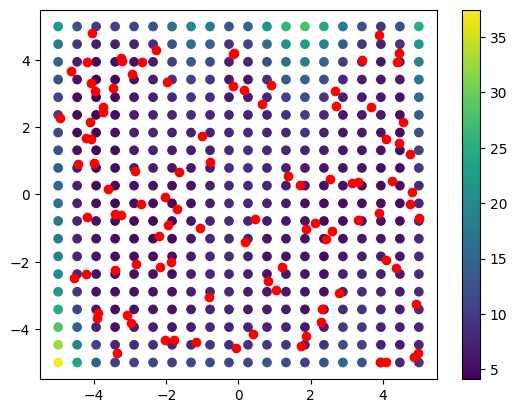

In [20]:
var_test = [torch.sqrt(gp_var(x)*s2) for x in x_test]
plt.scatter(x_test[:,0], x_test[:,1], c=var_test)
plt.colorbar()
plt.scatter(alpha[:,0], alpha[:,1], color="r")

There standard deviations are not that bad. We can try to combine the two.

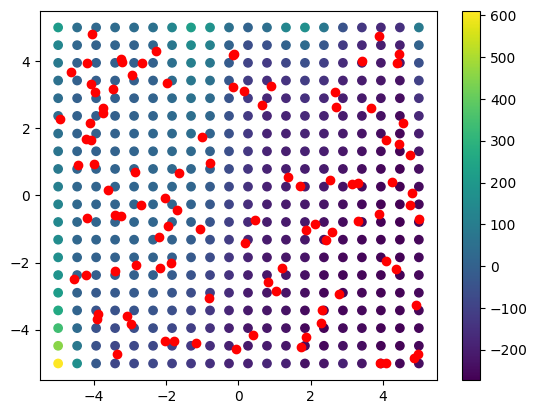

In [72]:
log_mean = [gp_mean(x)*torch.sqrt(s2)+mu + 1/2*gp_var(x)*s2 for x in x_test]
plt.scatter(x_test[:,0], x_test[:,1], c=log_mean)
plt.colorbar()
plt.scatter(alpha[:,0], alpha[:,1], color="r")

The heavy tails of the variane term dominate, meaning this might not be the best strategy.

In [22]:
def grad_rbf(l, sf2):
    """ Compute the prior covariance of the observation values and its
    gradients """
    return sf2*torch.diag(torch.tensor([1+1e-4/sf2, *(1/l**2)]))
# grad_rbf(lp, sp2)

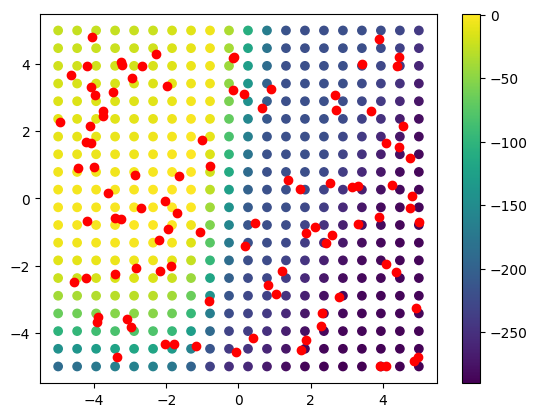

In [106]:
true_lml = [gp_lml(x, y, torch.exp(t[:d]), torch.exp(t[-1]), this_noise) for t in x_test]
plt.scatter(x_test[:,0], x_test[:,1], c=true_lml)
plt.colorbar()
plt.scatter(alpha[:,0], alpha[:,1], color="r")

Finally the true lml.

Sample a value (1 component) and a gradient (4 component)

In [23]:
def sample_one(zeta, Kinv, lp, sp2):
    k = cross_rbf(zeta, alpha, lp, sp2)
    kKi = k @ Kinv
    mean =  kKi @ gamma
    kss = grad_rbf(lp, sp2)
    variance = kss - kKi @ k.T
    L = torch.linalg.cholesky(variance)
    out = mean + L @ torch.randn(len(mean)) # GP prediction
    return out

In [24]:
# zeta = torch.randn(d+1) # Sample starting at zeta
out = sample_one(zeta, Kinv, lp, sp2)
out

tensor([ 0.0178,  1.2690, -0.1874])

In [25]:
# Timing
for i in range(1000):
    out = sample_one(zeta, Kinv, lp, sp2)

For unadjusted MALA we only need gradients, we don't even need function evaluations! This is enough to get us off the ground for now. Also, we can conveniently find a step-size by just working with the scaled down model, since this will have reasonable gradients. We just need to scale down the priors contribution to the gradient.

In [26]:
grad_logptheta(zeta)/torch.sqrt(s2)

tensor([-7.5080e-06, -1.3772e-02])

Now let's implement the unadjusted MALA.

In [27]:
chains = []
burnin = 1000
# TODO - Modify to do simulated tempring
for i in range(4):
    zeta = torch.randn(d+1)
    tau = 0.1 /math.sqrt(s2) # Scale approximately by gradient size
    draws = []
    for i in range(10000):
        out = sample_one(zeta, Kinv, lp, sp2)
        grad_sample = out[1:]*math.sqrt(s2)
        grad_prior = grad_logptheta(zeta) # /math.sqrt(s2)
        grad = grad_prior + grad_sample
        cand = zeta + tau*grad + math.sqrt(2*tau)*torch.randn(d+1)
        if torch.all(cand > -bounds) and torch.all(cand < bounds):
            zeta = cand
        draws.append(zeta)
    chains.append(draws[burnin:])

In [28]:
# Visualize
idata = az.from_dict(
    posterior = {
        "theta": chains
    }
)

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

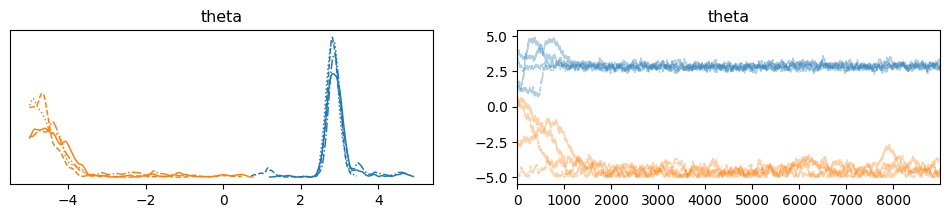

In [29]:
az.plot_trace(idata)

<Axes: xlabel='theta\n0', ylabel='theta\n1'>

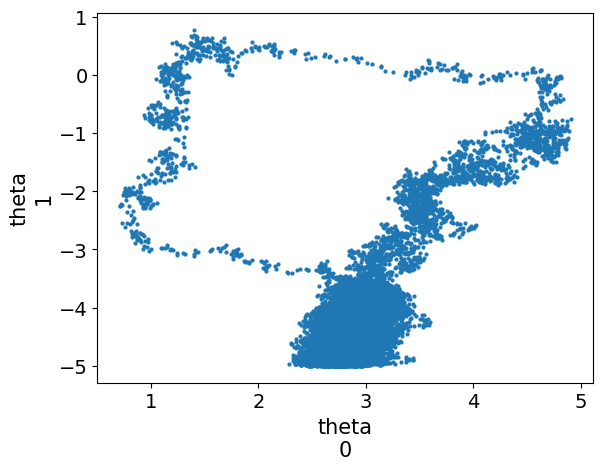

In [30]:
az.plot_pair(idata)

In [48]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],2.878,0.383,2.442,3.528,0.065,0.102,69.0,27.0,1.05
theta[1],-4.266,0.892,-5.000,-2.461,0.163,0.239,52.0,41.0,1.05


In [49]:
theta

tensor([-1.4710,  0.2610])

## Mean approximation
We now fit the mean approximation with STAN

In [50]:
Kinv

tensor([[ 8.1812e+01, -5.0765e-02, -2.2243e-01,  ..., -8.7740e-01,
         -7.8826e+00, -5.7505e-03],
        [-5.0765e-02,  7.6692e+01, -8.9728e-01,  ..., -9.3485e-02,
         -2.8377e-03, -1.5267e-01],
        [-2.2243e-01, -8.9728e-01,  4.4931e+01,  ...,  1.5439e+00,
          2.5467e-01, -1.3781e+00],
        ...,
        [-8.7740e-01, -9.3485e-02,  1.5439e+00,  ...,  7.8386e+01,
          5.6677e-01,  3.7930e-01],
        [-7.8826e+00, -2.8377e-03,  2.5467e-01,  ...,  5.6677e-01,
          6.9048e+01,  4.6807e-03],
        [-5.7505e-03, -1.5267e-01, -1.3781e+00,  ...,  3.7930e-01,
          4.6807e-03,  5.6447e+01]])

In [51]:
import cmdstanpy as csp

In [85]:
# a = Kinv @ gamma # representer weights for mean

# Data to pass to stan
data = {
    "m": m, # Number of data points in surrogate model
    "d": d, # Dimension of data points
    "Kinv": Kinv.numpy(), # Inverse covariance matrix (includig noise)
    "alpha": alpha.numpy(),
    "gamma": gamma.numpy(), # likelihood at observations
    "l": lp.numpy(), # Surrogate length scale vector length d+1
    "sf2": sp2.numpy(), # Surrogate out put scale
    "mu": mu.numpy(), # Centering for likelihood
    "s2": s2.numpy(), # Scaling factor
    "bound": bounds,
}

In [94]:
model  = csp.CmdStanModel(stan_file = "mean.stan")
sample_mean = model.sample(data = data, seed = 123, chains = 4, iter_sampling = 9000,
                      iter_warmup=1000, show_progress=False, show_console=False)

12:54:56 - cmdstanpy - INFO - CmdStan start processing
12:54:56 - cmdstanpy - INFO - Chain [1] start processing
12:54:56 - cmdstanpy - INFO - Chain [2] start processing
12:54:56 - cmdstanpy - INFO - Chain [3] start processing
12:54:56 - cmdstanpy - INFO - Chain [4] start processing
12:54:57 - cmdstanpy - INFO - Chain [3] done processing
12:54:57 - cmdstanpy - INFO - Chain [4] done processing
12:54:57 - cmdstanpy - INFO - Chain [2] done processing
12:54:57 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
az.summary(sample_mean)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],-1.218,0.133,-1.467,-0.986,0.002,0.003,8945.0,5714.0,1.0
theta[1],3.301,0.861,1.715,4.840,0.010,0.010,8102.0,6479.0,1.0


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

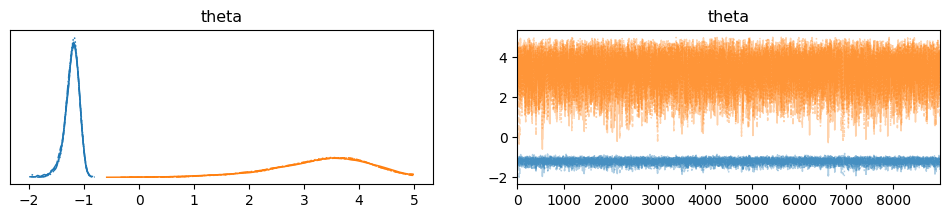

In [96]:
az.plot_trace(sample_mean)

<Axes: xlabel='theta\n0', ylabel='theta\n1'>

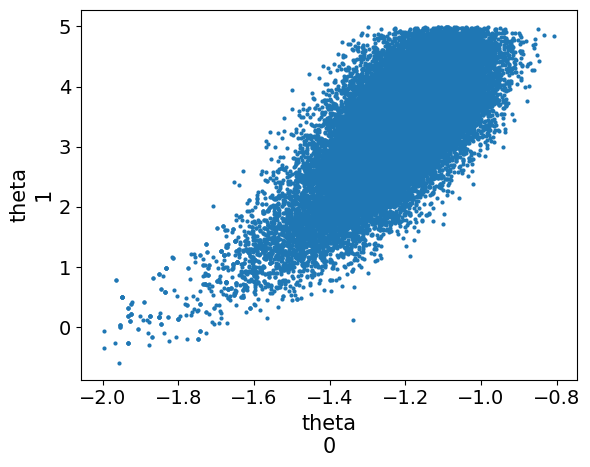

In [97]:
az.plot_pair(sample_mean)

In [98]:
model  = csp.CmdStanModel(stan_file = "lognorm.stan")
sample_log = model.sample(data = data, seed = 123, chains = 4, iter_sampling = 9000,
                      iter_warmup=1000, show_progress=False, show_console=False)

12:55:20 - cmdstanpy - INFO - CmdStan start processing
12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:20 - cmdstanpy - INFO - Chain [2] start processing
12:55:20 - cmdstanpy - INFO - Chain [3] start processing
12:55:20 - cmdstanpy - INFO - Chain [4] start processing
12:55:21 - cmdstanpy - INFO - Chain [1] done processing
12:55:21 - cmdstanpy - INFO - Chain [2] done processing
12:55:21 - cmdstanpy - INFO - Chain [3] done processing
12:55:21 - cmdstanpy - INFO - Chain [4] done processing


In [99]:
az.summary(sample_log)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],-3.095,1.904,-5.0,-1.144,0.951,0.0,6.0,89.0,1.73
theta[1],-0.002,4.995,-5.0,4.999,2.497,0.0,6.0,97.0,1.73


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

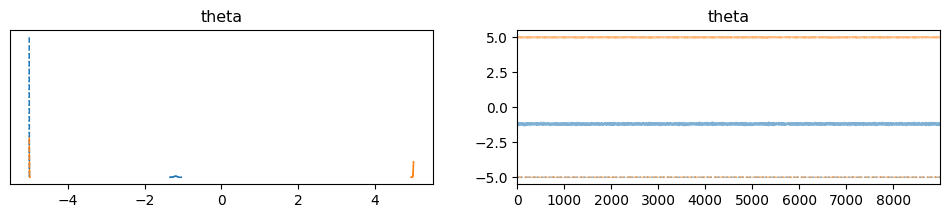

In [100]:
az.plot_trace(sample_log)

<Axes: xlabel='theta\n0', ylabel='theta\n1'>

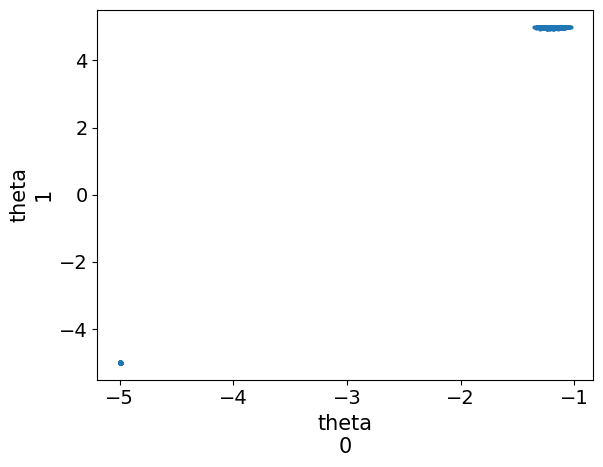

In [101]:
az.plot_pair(sample_log)

The log normal model really sucks.

In [83]:
data = {
    "n":n,
    "d":d,
    "x":x.numpy(),
    "y":y.numpy(),
    "sn2":noise,
    "bound": bounds,
}

model  = csp.CmdStanModel(stan_file = "lml.stan")
sample_gold = model.sample(data = data, seed = 123, chains = 4, iter_sampling = 1000,
                      iter_warmup=1000, show_progress=False, show_console=False)

12:53:38 - cmdstanpy - INFO - CmdStan start processing
12:53:38 - cmdstanpy - INFO - Chain [1] start processing
12:53:38 - cmdstanpy - INFO - Chain [2] start processing
12:53:38 - cmdstanpy - INFO - Chain [3] start processing
12:53:38 - cmdstanpy - INFO - Chain [4] start processing
12:53:38 - cmdstanpy - INFO - Chain [1] done processing
12:53:38 - cmdstanpy - INFO - Chain [2] done processing
12:53:39 - cmdstanpy - INFO - Chain [4] done processing
12:53:39 - cmdstanpy - INFO - Chain [3] done processing


In [69]:
az.summary(sample_gold)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],-3.006,0.335,-3.626,-2.375,0.010,0.007,1096.0,1191.0,1.0
theta[1],0.341,0.404,-0.364,1.080,0.012,0.012,1302.0,915.0,1.0
l[0],0.052,0.017,0.020,0.082,0.001,0.000,1096.0,1191.0,1.0
sf2,1.539,0.762,0.630,2.822,0.026,0.050,1302.0,915.0,1.0


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

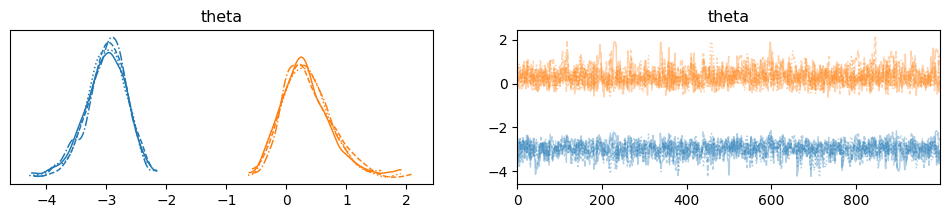

In [70]:
az.plot_trace(sample_gold, var_names = ["theta"])

<Axes: xlabel='theta\n0', ylabel='theta\n1'>

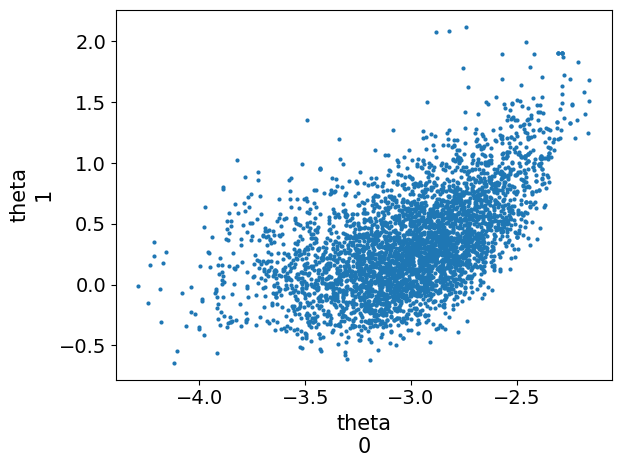

In [71]:
az.plot_pair(sample_gold, var_names=["theta"])

This is kind of similar to what our surrogate model gives.